In [10]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os 
from warnings import simplefilter
import pandas as pd
from imblearn.over_sampling import SMOTE  


In [11]:
import models
import class_sampling
import train
import metric_utils
import inference
import loss_fns
import torchvision.ops 

In [12]:
NUM_CLASSES = 10
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
momentum = 0

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

NUM_CLASSES_REDUCED = 2
nums = (6, 8)
ratio = (10, 1)


simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [13]:
train_MNIST = torchvision.datasets.MNIST('mnist', train=True, download=True)

test_MNIST = torchvision.datasets.MNIST('mnist', train=False, download=True)


    
reduced_train_MNIST = class_sampling.Reduce(train_MNIST, NUM_CLASSES_REDUCED, nums=nums, CIFAR=False)
reduced_test_MNIST = class_sampling.Reduce(test_MNIST, NUM_CLASSES_REDUCED, nums=nums, CIFAR=False)

ratio_train_MNIST = class_sampling.Ratio(train_MNIST, NUM_CLASSES_REDUCED, ratio, nums=nums, CIFAR=False)

smote_train_MNIST = class_sampling.Smote(ratio_train_MNIST, CIFAR=False)

In [14]:
targets = ratio_train_MNIST.labels 

class_count = np.unique(targets, return_counts=True)[1]
print(class_count)

weight = 1. / class_count

samples_weight = weight[targets]
samples_weight = torch.from_numpy(samples_weight)
oversampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(max(class_count) * NUM_CLASSES_REDUCED), replacement=True)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
undersampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(min(class_count) * NUM_CLASSES_REDUCED), replacement=False)

weight *= class_count[0]

[5918  585]


In [15]:
train_loader_reduced = DataLoader(reduced_train_MNIST, batch_size=batch_size_train, shuffle=True)  

train_loader_ratio = DataLoader(ratio_train_MNIST, batch_size=batch_size_train, shuffle=True) 

train_loader_oversampled = DataLoader(ratio_train_MNIST, batch_size=batch_size_train, sampler=oversampler)

train_loader_undersampled = DataLoader(ratio_train_MNIST, batch_size=batch_size_train, sampler=undersampler)

train_loader_sampled = DataLoader(ratio_train_MNIST, batch_size=batch_size_train, sampler=sampler)

train_loader_smote = DataLoader(smote_train_MNIST, batch_size=batch_size_train, shuffle=True)

test_loader_reduced = DataLoader(reduced_test_MNIST, batch_size=batch_size_test, shuffle=True)

In [16]:
col_names = ["name", 
            "num_classes", 
            "classes_used", 
            "ratio", 
            "learning_rate", 
            "mean_0", "variance_0",
            "mean_10", "variance_10",
            "mean_20", "variance_20",
            "mean_30", "variance_30",
            "mean_40", "variance_40",
            "mean_50", "variance_50"]

rows = []

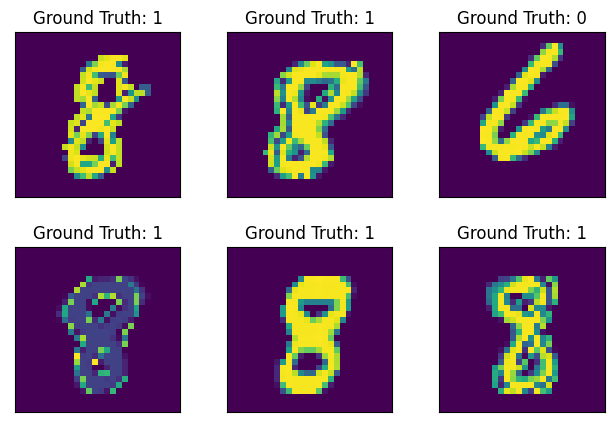

In [17]:
examples = enumerate(train_loader_smote) # enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i].reshape(28, 28).int())
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [37]:
# 2 class normal

momentum=0
learning_rates = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=28*28)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_reduced, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)


auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)


for i in range(len(learning_rates)): 
    row = ["normal", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)
   


Test set: Avg. loss: 0.014997146638037008, AUC: 0.529106990521835


Test set: Avg. loss: 0.00034093719523392357, AUC: 0.9943033484372387


Test set: Avg. loss: 0.0002675596971689544, AUC: 0.9967570186005239


Test set: Avg. loss: 0.00022661456872957833, AUC: 0.9970763868943257


Test set: Avg. loss: 0.00020036267166799145, AUC: 0.9972650070946916


Test set: Avg. loss: 0.00018535045363147806, AUC: 0.9973175206732027


Test set: Avg. loss: 0.013857130184923887, AUC: 0.5795264561265128


Test set: Avg. loss: 0.0002917447831196321, AUC: 0.99599717927064


Test set: Avg. loss: 0.00022872275910022096, AUC: 0.9971503345865145


Test set: Avg. loss: 0.0002035129637945266, AUC: 0.996977789971407


Test set: Avg. loss: 0.00018738947546506767, AUC: 0.9976363531141624


Test set: Avg. loss: 0.00017666397519857, AUC: 0.9978555169265196


Test set: Avg. loss: 0.03356571868833301, AUC: 0.47016264205458846


Test set: Avg. loss: 0.0003127128379438728, AUC: 0.9945262632194897


Test set: Avg. loss: 0


Test set: Avg. loss: 0.0005274283898296317, AUC: 0.9901654927917076


Test set: Avg. loss: 0.0004735380781363256, AUC: 0.9920098982736966


Test set: Avg. loss: 0.00043891538435874764, AUC: 0.9925693286406915


Test set: Avg. loss: 0.010137769252863978, AUC: 0.7027436737213479


Test set: Avg. loss: 0.0043213530356839575, AUC: 0.8707233584684039


Test set: Avg. loss: 0.0025608429750793964, AUC: 0.9291307823880175


Test set: Avg. loss: 0.0017684388358153666, AUC: 0.9540056071641383


Test set: Avg. loss: 0.001364466134559047, AUC: 0.9649016388523317


Test set: Avg. loss: 0.0011105834512236696, AUC: 0.9711169959660999


Test set: Avg. loss: 0.048457402373446194, AUC: 0.3141201510676332


Test set: Avg. loss: 0.006812155123329558, AUC: 0.7461391802737565


Test set: Avg. loss: 0.003984872598825775, AUC: 0.8655668465703275


Test set: Avg. loss: 0.002915234669395115, AUC: 0.9103711102442202


Test set: Avg. loss: 0.0023524123195782457, AUC: 0.9318936396411073


Test set: Avg. loss: 0.0


Test set: Avg. loss: 0.00833857972676216, AUC: 0.6963016508554354


Test set: Avg. loss: 0.006892785769318449, AUC: 0.7331501073849096


Test set: Avg. loss: 0.006088448360593176, AUC: 0.7655322304767376


Test set: Avg. loss: 0.005489326165082785, AUC: 0.7905281579951386


Test set: Avg. loss: 0.009097732125355343, AUC: 0.6782385874061722


Test set: Avg. loss: 0.008991921663777921, AUC: 0.6821578150921881


Test set: Avg. loss: 0.008889611956989295, AUC: 0.6863058519417164


Test set: Avg. loss: 0.008770341952148184, AUC: 0.6901023693269259


Test set: Avg. loss: 0.008677660801889487, AUC: 0.6939915892537927


Test set: Avg. loss: 0.008580556320601122, AUC: 0.6975367916561283


Test set: Avg. loss: 0.024767556792707424, AUC: 0.4853594286522657


Test set: Avg. loss: 0.023870162095095553, AUC: 0.48406159306906493


Test set: Avg. loss: 0.023036159096790892, AUC: 0.48444847882095227


Test set: Avg. loss: 0.02227768197069504, AUC: 0.48439060671402173


Test set: Avg. loss: 0.021459959

In [38]:
# 2 class ratio

momentum=0
learning_rates = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=28*28)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_oversampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)


auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

    
for i in range(len(learning_rates)): 
    row = ["ratio", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


Test set: Avg. loss: 0.015434165919049185, AUC: 0.586560060529937


Test set: Avg. loss: 0.00047162366456373386, AUC: 0.9941243735880276


Test set: Avg. loss: 0.00047194522730311994, AUC: 0.9953359368636747


Test set: Avg. loss: 0.0004681238353129006, AUC: 0.9955384892379315


Test set: Avg. loss: 0.0004896215060976475, AUC: 0.9955449194720349


Test set: Avg. loss: 0.0004768311730576351, AUC: 0.9955829650238133


Test set: Avg. loss: 0.01628745120504628, AUC: 0.5384179695035431


Test set: Avg. loss: 0.00043066131340544167, AUC: 0.9957581889031306


Test set: Avg. loss: 0.0004368295303042631, AUC: 0.9965710776643675


Test set: Avg. loss: 0.0005211861298938222, AUC: 0.9964960582664946


Test set: Avg. loss: 0.0005566760373164902, AUC: 0.996480518534078


Test set: Avg. loss: 0.0005875051515196175, AUC: 0.9964006764606277


Test set: Avg. loss: 0.010564863311578028, AUC: 0.7375891123276161


Test set: Avg. loss: 0.0005165793726656502, AUC: 0.9948579561286562


Test set: Avg. loss: 0


Test set: Avg. loss: 0.0005322696166749326, AUC: 0.9914831549300605


Test set: Avg. loss: 0.0005213938823151045, AUC: 0.9925859400787919


Test set: Avg. loss: 0.010889808090083594, AUC: 0.6292696754446506


Test set: Avg. loss: 0.004488938837071137, AUC: 0.8496745229838001


Test set: Avg. loss: 0.0028764699310002612, AUC: 0.9129426680327342


Test set: Avg. loss: 0.002171325078908948, AUC: 0.9410058172184521


Test set: Avg. loss: 0.0017706683950641387, AUC: 0.9549363835506038


Test set: Avg. loss: 0.0015267168883211124, AUC: 0.9638208236701205


Test set: Avg. loss: 0.028033436208531475, AUC: 0.26128827596850046


Test set: Avg. loss: 0.007363331490668697, AUC: 0.7411209184089029


Test set: Avg. loss: 0.0038302429714558287, AUC: 0.8827227111581708


Test set: Avg. loss: 0.0025852392919315315, AUC: 0.9272895920230801


Test set: Avg. loss: 0.0019614726119900343, AUC: 0.9495537417532246


Test set: Avg. loss: 0.0016043204698503388, AUC: 0.9608307648120442


Test set: Avg. loss: 0.


Test set: Avg. loss: 0.005001779668819831, AUC: 0.8133662061190108


Test set: Avg. loss: 0.004603371363495695, AUC: 0.8281755711119589


Test set: Avg. loss: 0.004293489653624857, AUC: 0.8413216488834971


Test set: Avg. loss: 0.014020731236870492, AUC: 0.43190435669794625


Test set: Avg. loss: 0.01384871346609933, AUC: 0.4386700346803959


Test set: Avg. loss: 0.013656736654277668, AUC: 0.44526263219489615


Test set: Avg. loss: 0.013476063252482602, AUC: 0.45194471713400175


Test set: Avg. loss: 0.013284212313823818, AUC: 0.45871575364487105


Test set: Avg. loss: 0.013124383507801632, AUC: 0.46412197296729585


Test set: Avg. loss: 0.04839635931927225, AUC: 0.5068401615274807


Test set: Avg. loss: 0.046927758131955224, AUC: 0.5083978857390269


Test set: Avg. loss: 0.04539537923429817, AUC: 0.5120277528903902


Test set: Avg. loss: 0.04376915917880293, AUC: 0.514126152619463


Test set: Avg. loss: 0.04220761127353455, AUC: 0.5151887488050482


Test set: Avg. loss: 0.04070265199

In [39]:
# 2 class oversampled

momentum=0
learning_rates = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=28*28)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_oversampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)
   

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

    
for i in range(len(learning_rates)): 
    row = ["oversampled", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


Test set: Avg. loss: 0.02059953010353736, AUC: 0.32781279873795943


Test set: Avg. loss: 0.0005200702241982486, AUC: 0.9947797216137316


Test set: Avg. loss: 0.0005176582568427298, AUC: 0.9949672701084137


Test set: Avg. loss: 0.0005116876422988702, AUC: 0.9951516034860443


Test set: Avg. loss: 0.0005180294746937959, AUC: 0.9951408864292053


Test set: Avg. loss: 0.0005392106886235823, AUC: 0.9951290976666824


Test set: Avg. loss: 0.01974508234185955, AUC: 0.4221475481517364


Test set: Avg. loss: 0.000617082012859684, AUC: 0.9935440449601969


Test set: Avg. loss: 0.0006120305192149697, AUC: 0.9944951837546565


Test set: Avg. loss: 0.0006366217697876087, AUC: 0.9952791364624282


Test set: Avg. loss: 0.0006411895001650351, AUC: 0.9963738838185302


Test set: Avg. loss: 0.0006284191124681114, AUC: 0.996050228701993


Test set: Avg. loss: 0.012246092900973176, AUC: 0.5678904116635873


Test set: Avg. loss: 0.0006060551072993387, AUC: 0.9936142416824921


Test set: Avg. loss: 0.00


Test set: Avg. loss: 0.0007510473701030818, AUC: 0.9916653448963233


Test set: Avg. loss: 0.0007364097404183808, AUC: 0.992445546634201


Test set: Avg. loss: 0.012717402499655018, AUC: 0.7021885301770887


Test set: Avg. loss: 0.0032795123431993566, AUC: 0.8978782370870182


Test set: Avg. loss: 0.0023585265467625967, AUC: 0.934192448333069


Test set: Avg. loss: 0.0019331971804300945, AUC: 0.952396441079765


Test set: Avg. loss: 0.0016654847694973522, AUC: 0.9617974433389206


Test set: Avg. loss: 0.001480100441176452, AUC: 0.9687217337625873


Test set: Avg. loss: 0.01639600866329596, AUC: 0.5948764966369876


Test set: Avg. loss: 0.0036197650259819584, AUC: 0.869995670309037


Test set: Avg. loss: 0.0023232798398651693, AUC: 0.927713987473904


Test set: Avg. loss: 0.0018095176042236896, AUC: 0.9512207799445285


Test set: Avg. loss: 0.0015453259396997299, AUC: 0.9613998405301943


Test set: Avg. loss: 0.0013573305453819765, AUC: 0.9686649333613407


Test set: Avg. loss: 0.01627


Test set: Avg. loss: 0.006660650729145816, AUC: 0.7722293192954177


Test set: Avg. loss: 0.0060753738411218235, AUC: 0.7909557685630142


Test set: Avg. loss: 0.005611769407679082, AUC: 0.8074809343558835


Test set: Avg. loss: 0.018042430127382773, AUC: 0.35864523541087057


Test set: Avg. loss: 0.017737667012658918, AUC: 0.36503742396248173


Test set: Avg. loss: 0.017420577213137292, AUC: 0.3713347665610679


Test set: Avg. loss: 0.017151203708372253, AUC: 0.3773207786584817


Test set: Avg. loss: 0.01686673529646658, AUC: 0.3826734126967116


Test set: Avg. loss: 0.01656608700011828, AUC: 0.38866853429243853


Test set: Avg. loss: 0.010033122747828008, AUC: 0.6107168424978459


Test set: Avg. loss: 0.00991231758402001, AUC: 0.6142941960706982


Test set: Avg. loss: 0.00978261787698876, AUC: 0.6188076845584358


Test set: Avg. loss: 0.009670870644705636, AUC: 0.6247299301676577


Test set: Avg. loss: 0.00954044284781067, AUC: 0.628655588087777


Test set: Avg. loss: 0.009452651499

In [40]:
# 2 class undersampled

momentum=0
learning_rates = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=28*28)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_undersampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)


auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

    
for i in range(len(learning_rates)): 
    row = ["undersampled", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


Test set: Avg. loss: 0.025259452330152934, AUC: 0.47413920599469295


Test set: Avg. loss: 0.0009826663303079072, AUC: 0.9834807285883921


Test set: Avg. loss: 0.0008517812868082745, AUC: 0.9909269396801174


Test set: Avg. loss: 0.0006412443228636716, AUC: 0.9927397298444312


Test set: Avg. loss: 0.000599567070757627, AUC: 0.9933452435558338


Test set: Avg. loss: 0.0005468863446273171, AUC: 0.9936769364650002


Test set: Avg. loss: 0.015795771873268773, AUC: 0.4420485868488852


Test set: Avg. loss: 0.001099562854747101, AUC: 0.9834684039730273


Test set: Avg. loss: 0.0007424404532272623, AUC: 0.990677768108611


Test set: Avg. loss: 0.0005826917370900851, AUC: 0.9929026291083838


Test set: Avg. loss: 0.0005142473255131802, AUC: 0.9938403715817947


Test set: Avg. loss: 0.0004954260637054285, AUC: 0.9947995481688836


Test set: Avg. loss: 0.017985747714467176, AUC: 0.474496619840273


Test set: Avg. loss: 0.0011684125748233519, AUC: 0.980765026385394


Test set: Avg. loss: 0.000


Test set: Avg. loss: 0.0014023429735353522, AUC: 0.9720852820515018


Test set: Avg. loss: 0.028508821135969142, AUC: 0.2438108996754875


Test set: Avg. loss: 0.024683232633223445, AUC: 0.29533207872321277


Test set: Avg. loss: 0.0211319479142657, AUC: 0.3532984957539021


Test set: Avg. loss: 0.01803111437685001, AUC: 0.4147945754545104


Test set: Avg. loss: 0.015439861803074554, AUC: 0.47698565629112666


Test set: Avg. loss: 0.013303249765873942, AUC: 0.5370472579338372


Test set: Avg. loss: 0.026503448407348886, AUC: 0.5624097087961316


Test set: Avg. loss: 0.01763462576066485, AUC: 0.5753328717854188


Test set: Avg. loss: 0.01429747103657535, AUC: 0.6005844011094297


Test set: Avg. loss: 0.012676069701927296, AUC: 0.6292895019998028


Test set: Avg. loss: 0.011549829696276173, AUC: 0.6582068006155878


Test set: Avg. loss: 0.010552035602229969, AUC: 0.6853113090670588


Test set: Avg. loss: 0.02109317996733924, AUC: 0.553629224127953


Test set: Avg. loss: 0.01388849876435


Test set: Avg. loss: 0.017274150690430194, AUC: 0.3486665837880938


Test set: Avg. loss: 0.01725076098866591, AUC: 0.3494424987032361


Test set: Avg. loss: 0.01723363187248909, AUC: 0.35021787776553653


Test set: Avg. loss: 0.017191434745709593, AUC: 0.35110739348317205


Test set: Avg. loss: 0.017156970180092886, AUC: 0.3516603936160636


Test set: Avg. loss: 0.02348236218249082, AUC: 0.29716523129552075


Test set: Avg. loss: 0.02347729171531788, AUC: 0.2976919746391567


Test set: Avg. loss: 0.023424259130505547, AUC: 0.2978248661439601


Test set: Avg. loss: 0.02338111770819433, AUC: 0.2983928701564261


Test set: Avg. loss: 0.023352496619056716, AUC: 0.2988397714266117


Test set: Avg. loss: 0.023319610650988594, AUC: 0.29930274828205583


Test set: Avg. loss: 0.03364902401562803, AUC: 0.2972916925662208


Test set: Avg. loss: 0.033554815604326396, AUC: 0.294843916784197


Test set: Avg. loss: 0.03342587903419637, AUC: 0.2926796071555645


Test set: Avg. loss: 0.03324367096705

In [41]:
# 2 class weighted

momentum=0
learning_rates = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9]

learning_rate_aucs = []

loss_fn_args = {}
loss_fn_args['pos_weight'] = torch.tensor([weight[1]])

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=28*28)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)


auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

    
for i in range(len(learning_rates)): 
    row = ["weighted", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


Test set: Avg. loss: 0.017008969996039666, AUC: 0.4984679967248675


Test set: Avg. loss: 0.0005603974095042448, AUC: 0.9940472107787871


Test set: Avg. loss: 0.0005973111028256624, AUC: 0.995270026964115


Test set: Avg. loss: 0.0005974054922721894, AUC: 0.9954104204087056


Test set: Avg. loss: 0.0005906756743634463, AUC: 0.9955352741208798


Test set: Avg. loss: 0.0006257031521688584, AUC: 0.9964397937180899


Test set: Avg. loss: 0.03125310487135103, AUC: 0.4181972410008873


Test set: Avg. loss: 0.0006459708601298046, AUC: 0.9945803843565264


Test set: Avg. loss: 0.0007238506530382619, AUC: 0.9947990123160417


Test set: Avg. loss: 0.0008245322768485817, AUC: 0.995249128703279


Test set: Avg. loss: 0.000738330108285197, AUC: 0.9955272363282506


Test set: Avg. loss: 0.0007196388999867883, AUC: 0.995691207297887


Test set: Avg. loss: 0.022401894595065225, AUC: 0.32051448303061214


Test set: Avg. loss: 0.0006671747497396687, AUC: 0.9946870190720744


Test set: Avg. loss: 0.000


Test set: Avg. loss: 0.0005815412625516177, AUC: 0.9907201004831249


Test set: Avg. loss: 0.0005510169742763907, AUC: 0.9916015784081312


Test set: Avg. loss: 0.0429279197076833, AUC: 0.511008560785003


Test set: Avg. loss: 0.005785764127537824, AUC: 0.8119687019072075


Test set: Avg. loss: 0.0032533862575981187, AUC: 0.9013537786199003


Test set: Avg. loss: 0.0022744600570473363, AUC: 0.9369461960878456


Test set: Avg. loss: 0.0017831691427013642, AUC: 0.9540120373982417


Test set: Avg. loss: 0.0015013299990391386, AUC: 0.9615005808644808


Test set: Avg. loss: 0.03230802267481328, AUC: 0.14692977755676823


Test set: Avg. loss: 0.007659684056821076, AUC: 0.7011864853626437


Test set: Avg. loss: 0.003727853915212564, AUC: 0.8705133041543599


Test set: Avg. loss: 0.0024848000356622857, AUC: 0.9243290050713113


Test set: Avg. loss: 0.0019553461060020493, AUC: 0.9446351485169737


Test set: Avg. loss: 0.0016293079586502928, AUC: 0.957464001406078


Test set: Avg. loss: 0.01649


Test set: Avg. loss: 0.0030176374236002227, AUC: 0.9169010129762123


Test set: Avg. loss: 0.0026602653736406724, AUC: 0.9279695892795138


Test set: Avg. loss: 0.0024775044518227903, AUC: 0.9342497845871575


Test set: Avg. loss: 0.01665117034754151, AUC: 0.49944217719153094


Test set: Avg. loss: 0.016447709954303245, AUC: 0.5040435455453481


Test set: Avg. loss: 0.01626822074747974, AUC: 0.5080131433985073


Test set: Avg. loss: 0.016035122407395894, AUC: 0.5119473749640978


Test set: Avg. loss: 0.01585993065843918, AUC: 0.5164737239200421


Test set: Avg. loss: 0.015698735511574437, AUC: 0.5205172694653903


Test set: Avg. loss: 0.01010664501545592, AUC: 0.7519890857493151


Test set: Avg. loss: 0.009418974752011507, AUC: 0.7578357761078223


Test set: Avg. loss: 0.00879349965239657, AUC: 0.7632612861325572


Test set: Avg. loss: 0.00822822672486552, AUC: 0.7684858513415612


Test set: Avg. loss: 0.007715740312453876, AUC: 0.7737773981558089


Test set: Avg. loss: 0.007257652578

In [42]:
# 2 class SMOTE

momentum=0
learning_rates = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9]

learning_rate_aucs = []


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=28*28)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_smote, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)


auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

    
for i in range(len(learning_rates)): 
    row = ["smote", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


Test set: Avg. loss: 0.047167061278538674, AUC: 0.2392877658365949


Test set: Avg. loss: 0.00045623506880201415, AUC: 0.9964054991362052


Test set: Avg. loss: 0.00040390655614327693, AUC: 0.9967473732493687


Test set: Avg. loss: 0.0003926855806978593, AUC: 0.9968084604733509


Test set: Avg. loss: 0.0004194700168773501, AUC: 0.9972532183321687


Test set: Avg. loss: 0.00041026875037337437, AUC: 0.9972462522452233


Test set: Avg. loss: 0.014488663979445432, AUC: 0.5211817269894072


Test set: Avg. loss: 0.00037133988324653043, AUC: 0.9954500735190099


Test set: Avg. loss: 0.0003817048594818352, AUC: 0.9955213419469892


Test set: Avg. loss: 0.00039651810999489226, AUC: 0.9960529079662027


Test set: Avg. loss: 0.00036910817983481207, AUC: 0.996154184153331


Test set: Avg. loss: 0.0003813507332318071, AUC: 0.9960989913106103


Test set: Avg. loss: 0.015022079396692123, AUC: 0.4698384510852092


Test set: Avg. loss: 0.000366702305604212, AUC: 0.995796770307751


Test set: Avg. loss


Test set: Avg. loss: 0.000725286470930522, AUC: 0.989414762960137


Test set: Avg. loss: 0.0006725180963551776, AUC: 0.9899463289793504


Test set: Avg. loss: 0.024510826876938466, AUC: 0.3556107007669126


Test set: Avg. loss: 0.0056829983156413515, AUC: 0.7760097610953689


Test set: Avg. loss: 0.0030601203565024933, AUC: 0.8936482147526716


Test set: Avg. loss: 0.0021707558113595714, AUC: 0.9326861659943498


Test set: Avg. loss: 0.0017243282518525054, AUC: 0.9504523669691735


Test set: Avg. loss: 0.001447187632507419, AUC: 0.9613580440085222


Test set: Avg. loss: 0.018804269794598375, AUC: 0.3043601274043717


Test set: Avg. loss: 0.004782377069287665, AUC: 0.7888964860914037


Test set: Avg. loss: 0.0024597099355535726, AUC: 0.9102253582712101


Test set: Avg. loss: 0.0017469313080513205, AUC: 0.9440339216283067


Test set: Avg. loss: 0.0014364365218342214, AUC: 0.9574061292991474


Test set: Avg. loss: 0.0012296164874951538, AUC: 0.9667819464747314


Test set: Avg. loss: 0.02


Test set: Avg. loss: 0.012929203594199865, AUC: 0.45976924033214306


Test set: Avg. loss: 0.01108596438453311, AUC: 0.5192505133470225


Test set: Avg. loss: 0.009620982914484313, AUC: 0.5762765086400912


Test set: Avg. loss: 0.011681524122723882, AUC: 0.5932619720241948


Test set: Avg. loss: 0.011517065652408955, AUC: 0.5975970215155633


Test set: Avg. loss: 0.011362241168446668, AUC: 0.6021967823108547


Test set: Avg. loss: 0.011212440751354146, AUC: 0.6058914876560939


Test set: Avg. loss: 0.011072680570077206, AUC: 0.6099762938702722


Test set: Avg. loss: 0.010949866371865598, AUC: 0.6135316774766046


Test set: Avg. loss: 0.010699937062233872, AUC: 0.6485223322030411


Test set: Avg. loss: 0.010165640532847024, AUC: 0.6588557184071882


Test set: Avg. loss: 0.009680783526497597, AUC: 0.6638536178640477


Test set: Avg. loss: 0.009260127756659782, AUC: 0.66770586394482


Test set: Avg. loss: 0.008841402535606368, AUC: 0.6738649565101833


Test set: Avg. loss: 0.008503688294

In [43]:

momentum=0
learning_rates = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9]


loss_fn_args = {}
loss_fn_args['reduction'] = 'mean'


learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=28*28)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn=loss_fns.SigmoidFocalLoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)


auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

    
for i in range(len(learning_rates)): 
    row = ["focal_loss", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


Test set: Avg. loss: 0.00995381722539108, AUC: 0.7384561222258899


Test set: Avg. loss: 0.0030169588191662267, AUC: 0.9752157343541688


Test set: Avg. loss: 0.0021965423479336885, AUC: 0.9844002520651768


Test set: Avg. loss: 0.001858554456544959, AUC: 0.9876357315248658


Test set: Avg. loss: 0.0017254860998434064, AUC: 0.9891012890475965


Test set: Avg. loss: 0.0015510958050595554, AUC: 0.9901403077081359


Test set: Avg. loss: 0.01969920527614175, AUC: 0.49038733586827454


Test set: Avg. loss: 0.0016330346064044327, AUC: 0.9859113570794734


Test set: Avg. loss: 0.001119328396660941, AUC: 0.9908926450982325


Test set: Avg. loss: 0.0009483712615433687, AUC: 0.9923185495106592


Test set: Avg. loss: 0.000913108882203112, AUC: 0.9943087069656583


Test set: Avg. loss: 0.0008726360326474744, AUC: 0.9948933224162247


Test set: Avg. loss: 0.008244756586062982, AUC: 0.7884356526473275


Test set: Avg. loss: 0.002420156885624919, AUC: 0.9831463564150159


Test set: Avg. loss: 0.0019


Test set: Avg. loss: 0.0049528327787885015, AUC: 0.965035066209977


Test set: Avg. loss: 0.014483087551519738, AUC: 0.5431533010678475


Test set: Avg. loss: 0.01677851696685728, AUC: 0.6238988224097946


Test set: Avg. loss: 0.018930261426337264, AUC: 0.6546519528620972


Test set: Avg. loss: 0.018974582601037824, AUC: 0.6788419577062069


Test set: Avg. loss: 0.01831426975889976, AUC: 0.7005718621529281


Test set: Avg. loss: 0.01748123820524038, AUC: 0.7206106150304579


Test set: Avg. loss: 0.0290557573053901, AUC: 0.5020410634749842


Test set: Avg. loss: 0.016534687816232876, AUC: 0.5955232710172202


Test set: Avg. loss: 0.020092488322445572, AUC: 0.62957189644751


Test set: Avg. loss: 0.02080388197494096, AUC: 0.6554680567403857


Test set: Avg. loss: 0.020403145262913674, AUC: 0.6786093975728009


Test set: Avg. loss: 0.0196403904237609, AUC: 0.6999920693779391


Test set: Avg. loss: 0.03337555445005681, AUC: 0.16640159812751582


Test set: Avg. loss: 0.04327310242267869, A


Test set: Avg. loss: 0.007558618766674097, AUC: 0.7054850968607598


Test set: Avg. loss: 0.0402261169307227, AUC: 0.3062731220501301


Test set: Avg. loss: 0.040239928425222206, AUC: 0.30676021228346184


Test set: Avg. loss: 0.040261063269700074, AUC: 0.30729552927256903


Test set: Avg. loss: 0.04023169089054716, AUC: 0.30778154780021694


Test set: Avg. loss: 0.040275593475278613, AUC: 0.3080189306092004


Test set: Avg. loss: 0.04026850113957565, AUC: 0.308349551812683


Test set: Avg. loss: 0.012359107256429289, AUC: 0.7275204374273919


Test set: Avg. loss: 0.011905916482518672, AUC: 0.7312328259164156


Test set: Avg. loss: 0.011517731546121601, AUC: 0.7368421334659391


Test set: Avg. loss: 0.01106380083546135, AUC: 0.7405620238947499


Test set: Avg. loss: 0.010651532660853542, AUC: 0.7442331517149434


Test set: Avg. loss: 0.010298251118472398, AUC: 0.7485821333802026


Test set: Avg. loss: 0.010768839537973977, AUC: 0.8453539415191643


Test set: Avg. loss: 0.0108014382190

In [18]:
NUM_CLASSES_REDUCED = 3
nums = (6, 8, 9)
ratio = (20, 2, 1)


reduced_train_MNIST = class_sampling.Reduce(train_MNIST, NUM_CLASSES_REDUCED, nums=nums, CIFAR=False)
reduced_test_MNIST = class_sampling.Reduce(test_MNIST, NUM_CLASSES_REDUCED, nums=nums, CIFAR=False)

ratio_train_MNIST = class_sampling.Ratio(train_MNIST, NUM_CLASSES_REDUCED, ratio, nums=nums, CIFAR=False)
targets = ratio_train_MNIST.labels 
class_count = np.unique(targets, return_counts=True)[1]

smote_train_MNIST = class_sampling.Smote(ratio_train_MNIST, CIFAR=False)


weight = 1. / class_count
samples_weight = weight[targets]
samples_weight = torch.from_numpy(samples_weight)
oversampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(max(class_count) * NUM_CLASSES_REDUCED), replacement=True)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
undersampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(min(class_count) * NUM_CLASSES_REDUCED), replacement=False)

weight *= max(class_count)


train_loader_reduced = DataLoader(reduced_train_MNIST, batch_size=batch_size_train, shuffle=True)  

train_loader_ratio = DataLoader(ratio_train_MNIST, batch_size=batch_size_train, shuffle=True) 

train_loader_oversampled = DataLoader(ratio_train_MNIST, batch_size=batch_size_train, sampler=oversampler)

train_loader_undersampled = DataLoader(ratio_train_MNIST, batch_size=batch_size_train, sampler=undersampler)

train_loader_sampled = DataLoader(ratio_train_MNIST, batch_size=batch_size_train, sampler=sampler)

train_loader_smote = DataLoader(smote_train_MNIST, batch_size=batch_size_train, shuffle=True)

test_loader_reduced = DataLoader(reduced_test_MNIST, batch_size=batch_size_test, shuffle=True)

In [19]:
#  3 class normal

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=28*28)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_reduced, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["normal", 3, nums, (1, 1, 1), learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)



Test set: Avg. loss: 0.03784423537580223, AUC: 0.3768751506805761


Test set: Avg. loss: 0.0002918882420256769, AUC: 0.9819564945039094


Test set: Avg. loss: 0.0002367155349647784, AUC: 0.9842413121132969


Test set: Avg. loss: 0.00021068657571383375, AUC: 0.9871322735948673


Test set: Avg. loss: 0.00019660147983012092, AUC: 0.98688013037752


Test set: Avg. loss: 0.0001768489342609744, AUC: 0.9873670457763642


Test set: Avg. loss: 0.08897318705455336, AUC: 0.4928097071453914


Test set: Avg. loss: 0.00043320110645962185, AUC: 0.9835154133727497


Test set: Avg. loss: 0.0003763560746568111, AUC: 0.9837975611065666


Test set: Avg. loss: 0.00031749168977734184, AUC: 0.9845187222918818


Test set: Avg. loss: 0.0002995065506199354, AUC: 0.9848456136028897


Test set: Avg. loss: 0.00026802601598631317, AUC: 0.9863411018711238


Test set: Avg. loss: 0.03703024046066788, AUC: 0.5825095251179914


Test set: Avg. loss: 0.0004063983609667444, AUC: 0.9816988241387914


Test set: Avg. loss: 0


Test set: Avg. loss: 0.00037018958300564895, AUC: 0.9791518618065665


Test set: Avg. loss: 0.0003441834289660384, AUC: 0.9814724742777069


Test set: Avg. loss: 0.02674292091284022, AUC: 0.5338661503784254


Test set: Avg. loss: 0.0010156536823792831, AUC: 0.9490333808141647


Test set: Avg. loss: 0.0007460199420608577, AUC: 0.9631349771597197


Test set: Avg. loss: 0.0006313614093783112, AUC: 0.9682678550560768


Test set: Avg. loss: 0.0005685341617599793, AUC: 0.9716312560732826


Test set: Avg. loss: 0.0005159145895618437, AUC: 0.9744732628174556


Test set: Avg. loss: 0.02538277121151195, AUC: 0.6891629476858095


Test set: Avg. loss: 0.0008619942052232209, AUC: 0.9522533391868461


Test set: Avg. loss: 0.0005961156385928261, AUC: 0.9694222393476071


Test set: Avg. loss: 0.0005003327477833561, AUC: 0.9724740145095525


Test set: Avg. loss: 0.00044484035736117706, AUC: 0.9744911602483322


Test set: Avg. loss: 0.0004163205177757214, AUC: 0.975769510568433


Test set: Avg. loss: 0


Test set: Avg. loss: 0.0022894155002296966, AUC: 0.8917973968713186


Test set: Avg. loss: 0.001648501813188778, AUC: 0.9122288934018489


Test set: Avg. loss: 0.0013262001440987948, AUC: 0.9261691496720033


Test set: Avg. loss: 0.0011221100099635586, AUC: 0.937507698527252


Test set: Avg. loss: 0.030508711321019105, AUC: 0.5289132995808843


Test set: Avg. loss: 0.021972631605576998, AUC: 0.5165467012402919


Test set: Avg. loss: 0.017099089948387627, AUC: 0.546776514780646


Test set: Avg. loss: 0.01381555458024747, AUC: 0.5947982169947686


Test set: Avg. loss: 0.011457330716057564, AUC: 0.6374733249320688


Test set: Avg. loss: 0.00964582359575974, AUC: 0.6690349178876398


Test set: Avg. loss: 0.033029048469592745, AUC: 0.6946495630394891


Test set: Avg. loss: 0.012708336104750025, AUC: 0.757416642715693


Test set: Avg. loss: 0.008430247321415823, AUC: 0.7750182395876432


Test set: Avg. loss: 0.006657595700935538, AUC: 0.7872448168513788


Test set: Avg. loss: 0.005619126086

In [20]:
#  3 class ratio

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=28*28)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network, average=False) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network, average=False)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["ratio", 3, nums,ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


Test set: Avg. loss: 0.023154299261617807, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.017943383884527212, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.018413019682914374, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01711023603722742, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.017268284613159553, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01713702355222368, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.04787962212119934, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.014930541237289912, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01669713130


Test set: Avg. loss: 0.013084992062109176, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.013867020242192316, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.014506760279121386, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.015002217595976901, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.021894103448758195, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.009863119958736831, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.010459990049048939, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01154608079585361, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.012281122


Test set: Avg. loss: 0.011767812182164768, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.011882062754392705, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.10131313735147351, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01933097774501724, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.012585519325648064, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.0112442731938367, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.011200005000483135, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.011332142884047896, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.024835580711


Test set: Avg. loss: 0.030293819734896983, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.02427670810547705, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.02042776222579214, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01808262941424679, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.016674943215098766, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.04028465584888218, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.033884433044620375, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.025282562447826458, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.019476369464


Test set: Avg. loss: 0.04982165194254917, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.048844181490122804, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.026966390055241693, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.015898222665485174, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.012138242504297573, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.012216264477638678, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.012914014892163062, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.013398969469326607, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.038031881

In [21]:
#  3 class oversampled

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=28*28)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network, average=False) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_oversampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network, average=False)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["oversampled", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


Test set: Avg. loss: 0.025290647115645788, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.017568756228034815, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01691412220435741, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.017181602070745827, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.017222426205984957, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01736546016720354, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.021052315461315373, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01802598420797826, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01797276911


Test set: Avg. loss: 0.017295777088361143, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.016930734166803914, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.016982364232991674, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01682534748013836, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.04028489969896241, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.018842081032979654, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.017563504371785745, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.017517148860657715, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.0172890900


Test set: Avg. loss: 0.016319567068463804, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.016454276727276243, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.04022635362943554, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01654918791282262, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.016925641202229457, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01720189999577465, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.017024854460933183, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01626286511516863, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.043015653525


Test set: Avg. loss: 0.015923848649913135, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.014333278457553401, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.014466521773197261, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.014497019895198839, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.015385938720288062, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.05278348744381694, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01693824747313208, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.016431114536610968, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.0166885274


Test set: Avg. loss: 0.011508933543672533, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.011337766027985604, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.011173233698923058, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.026033830172510545, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.021426763472934842, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.02122045268577931, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.02061967353600298, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.019305837839406106, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.0179351669

In [22]:
# 3 class undersampled

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=28*28)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network, average=False) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_undersampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network, average=False)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["undersampled", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


Test set: Avg. loss: 0.03402413838739016, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.018554496181453016, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.018292381989635686, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.016142242662519957, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.017255459136599708, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.017447444055810828, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.12580166232703455, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.018920410737339553, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.0197413307


Test set: Avg. loss: 0.0156063701132859, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01549046544629836, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01540326569527033, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.016356523974904072, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.061373640914548624, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.018350040859934507, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.011931814007595338, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.011822794862686878, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.012373820165


Test set: Avg. loss: 0.01681691130502254, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01665051961909829, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.03294088499191788, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.024021263472768815, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.019416982890067155, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01742462072596182, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.017294725160621454, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.017194771272152794, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.038716217321


Test set: Avg. loss: 0.02014952798718216, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.017043732088952192, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.015431308130227316, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.014530877765446688, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.01395583939122651, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.03488179932885817, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.03196184897009348, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.029184859612084536, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.027319251497


Test set: Avg. loss: 0.020648043158102182, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.020679548458759578, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.02599310266935108, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.02461816372007223, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.023395789962607716, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.022309020197095616, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.021276916301562566, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.02030632099461612, AUC: [[2.16158446e-314 2.39347716e-314]
 [5.73386054e-314 2.39347731e-314]]


Test set: Avg. loss: 0.04432367313

In [23]:
# 3 class weighted

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

loss_fn_args={}
loss_fn_args['weight'] = torch.from_numpy(class_weights).float()


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=28*28)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network, average=False) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network, average=False)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["weighted", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)

NameError: name 'class_weights' is not defined

In [ ]:
# 3 class focal loss

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

loss_fn_args={}
loss_fn_args['reduction'] = 'mean'


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=28*28)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network, average=False) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn=loss_fns.SoftmaxFocalLoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network, average=False)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["focal_loss", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)

In [ ]:
# 3 class smote

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=28*28)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network, average=False) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_smote, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network, average=False)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["smote", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)